In [1]:
%load_ext autoreload
%autoreload 2

import os
import warnings

warnings.filterwarnings("ignore")
os.chdir("../")

In [2]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import seaborn as sns
from analysis import load_nft_trades, plot_correl_heatmap

In [3]:
nft_trades = load_nft_trades()

In [4]:
# finance.yahoo.com
gold = pd.read_csv("historic_data/gold.csv").iloc[:-1]
gold = (
    gold.assign(Date=pd.to_datetime(gold.Date).dt.date)
    .set_index("Date")[["Close*"]]
    .rename(columns={"Close*": "Gold"})
)
gold = gold[gold["Gold"] != "-"]
gold.Gold = gold.Gold.apply(lambda x: float(x.replace(",", "")))

In [5]:
# finance.yahoo.com
oil = pd.read_csv("historic_data/oil.csv", thousands=",").iloc[:-1]
oil = (
    oil.assign(Date=pd.to_datetime(oil.Date).dt.date)
    .set_index("Date")[["Close*"]]
    .rename(columns={"Close*": "Oil"})
)
oil = oil[oil["Oil"] != "-"]
oil.Oil = oil.Oil.apply(lambda x: float(x.replace(",", "")))

In [6]:
# finance.yahoo.com
bitcoin = pd.read_csv("historic_data/bitcoin.csv", thousands=",").iloc[:-1]
bitcoin = (
    bitcoin.assign(Date=pd.to_datetime(bitcoin.Date).dt.date)
    .set_index("Date")[["Close*"]]
    .rename(columns={"Close*": "Bitcoin"})
)
bitcoin = bitcoin[bitcoin["Bitcoin"] != "-"]

In [7]:
# VanEck Global Real Estate ISIN NL0009690239
real_estate = pd.read_csv("historic_data/real_estate.csv")
real_estate = (
    real_estate.assign(Date=pd.to_datetime(real_estate.Date).dt.date)
    .set_index("Date")[["Close*"]]
    .rename(columns={"Close*": "Real Estate"})
)

In [8]:
ether = pd.read_csv("historic_data/eth_usd.csv")
ether = (
    ether.assign(Date=pd.to_datetime(ether.Date).dt.date)
    .set_index("Date")
    .rename(columns={"ETH_in_USD": "Ether"})
)

In [9]:
spx = pd.read_csv("historic_data/spx.csv")
spx = (
    spx.assign(Date=pd.to_datetime(spx.Date).dt.date)
    .set_index("Date")
    .rename(columns={"spx": "S&P 500"})
)

In [10]:
nft_index = nft_trades.groupby("sell_date").median()
nft_index = (
    nft_index.reset_index()
    .assign(Date=pd.to_datetime(nft_index.reset_index().sell_date).dt.date)
    .set_index("Date")
)
nft_index = nft_index[["sell_price_usd"]].rename(
    columns={"sell_price_usd": "NFT Art Index"}
)

In [11]:
market = (
    nft_index.merge(spx, how="inner", left_index=True, right_index=True)
    .merge(ether, how="inner", left_index=True, right_index=True)
    .merge(bitcoin, how="inner", left_index=True, right_index=True)
    .merge(gold, how="inner", left_index=True, right_index=True)
    .merge(oil, how="inner", left_index=True, right_index=True)
    .merge(real_estate, how="inner", left_index=True, right_index=True)
)

In [12]:
market_weekly = market.rolling(30).median().pct_change()

In [13]:
market_weekly_correl = market_weekly.corr("pearson")

In [14]:
market_weekly

,NFT Art Index,S&P 500,Ether,Bitcoin,Gold,Oil,Real Estate
Date,,,,,,,
2020-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2022-09-28,-0.068085,-0.003130,-0.006029,-0.003917,-0.001402,0.000000,-0.001210
2022-09-29,0.000000,-0.002631,-0.007499,-0.006321,-0.001404,-0.000518,-0.001818
2022-09-30,0.000000,-0.002824,-0.002796,-0.004959,-0.002227,-0.001497,-0.003399


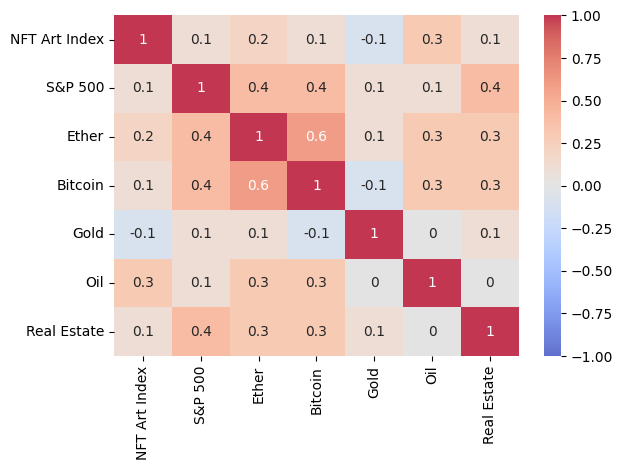

In [21]:
sns.heatmap(market_weekly_correl.round(1), annot=True, vmin=-1, vmax=1, cmap="coolwarm", alpha=0.8)
plt.tight_layout()
plt.savefig("figures/correl.png")